In [14]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn import metrics

from pmdarima.model_selection import train_test_split as time_train_test_split
import xgboost

from xgboost import XGBRegressor
from xgboost import plot_importance

import warnings
warnings.filterwarnings("ignore")

In [15]:
df=pd.read_csv('Readings_last_7yr.csv')
df

,Date,Date.1,Irr
0,2014-01-01 00:30:00,2014-01-01 00:30:00,0.00
1,2014-01-01 01:30:00,2014-01-01 01:30:00,0.00
2,2014-01-01 02:30:00,2014-01-01 02:30:00,1.45
3,2014-01-01 03:30:00,2014-01-01 03:30:00,150.72
4,2014-01-01 04:30:00,2014-01-01 04:30:00,373.87
...,...,...,...
61363,2020-12-31 19:30:00,2020-12-31 19:30:00,0.00
61364,2020-12-31 20:30:00,2020-12-31 20:30:00,0.00
61365,2020-12-31 21:30:00,2020-12-31 21:30:00,0.00
61366,2020-12-31 22:30:00,2020-12-31 22:30:00,0.00


In [16]:
del df['Date.1']

In [17]:
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')
df.head()

,Date,Irr
Date,,
2014-01-01 00:30:00,2014-01-01 00:30:00,0.00
2014-01-01 01:30:00,2014-01-01 01:30:00,0.00
2014-01-01 02:30:00,2014-01-01 02:30:00,1.45
2014-01-01 03:30:00,2014-01-01 03:30:00,150.72
2014-01-01 04:30:00,2014-01-01 04:30:00,373.87


In [18]:
df2 = df.copy()
del df2['Date']

In [19]:
df2.columns = ['Irradiance']

In [20]:
df2

,Irradiance
Date,
2014-01-01 00:30:00,0.00
2014-01-01 01:30:00,0.00
2014-01-01 02:30:00,1.45
2014-01-01 03:30:00,150.72
2014-01-01 04:30:00,373.87
...,...
2020-12-31 19:30:00,0.00
2020-12-31 20:30:00,0.00
2020-12-31 21:30:00,0.00


In [21]:
df.dtypes

Date     object
Irr     float64
dtype: object

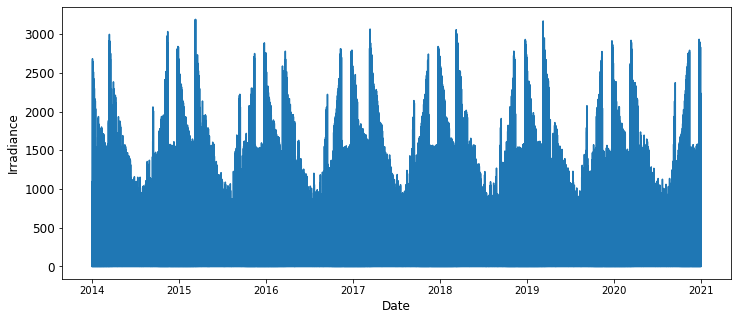

In [22]:

Irr = df2['Irradiance']
plt.figure(figsize=(12,5))
plt.ylabel("Irradiance", fontsize = 12)
plt.xlabel("Date", fontsize = 12)
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=12) 
# plt.legend(('TestY (Actual)','Predicted'))

plt.plot(Irr)


In [23]:
df2.dtypes

Irradiance    float64
dtype: object

Observations: 61368
Training Observations: 46026
Testing Observations: 15342


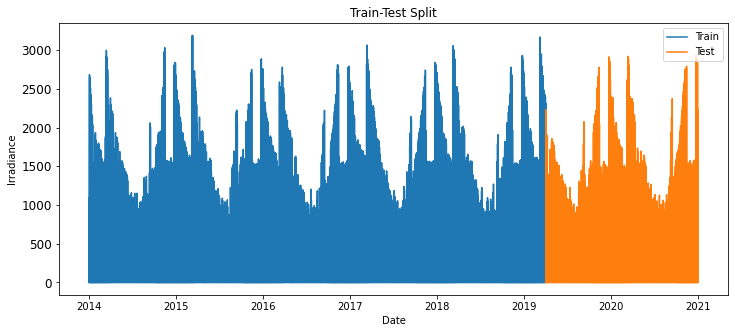

In [24]:
from pandas import read_csv
from matplotlib import pyplot
# series = read_csv('sunspots.csv', header=0, index_col=0)
X = df2
train_size = int(len(X) * 0.75)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
plt.figure(figsize=(12,5))

pyplot.plot(train)
pyplot.plot(test)
# plt.figure(figsize=(13,8))
plt.title("Train-Test Split")

plt.ylabel("Irradiance")
plt.xlabel("Date")
plt.legend(('Train','Test'))

# plt.figure(figsize=(13,8))
pyplot.show()
# pyplot.xlabel


In [25]:
def create_features(df, target_variable):
    """
    Creates time series features from datetime index
    
    Args:
        df (float64): Values to be added to the model incl. corresponding datetime
                      , numpy array of floats
        target_variable (string): Name of the target variable within df   
    
    Returns:
        X (int): Extracted values from datetime index, dataframe
        y (int): Values of target variable, numpy array of integers
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if target_variable:
        y = df[target_variable]
        return X, y
    return X

In [26]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        Mean absolute percentage error 
    '''    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    '''
    Calculate the following evaluation metrics:
        - MSE
        - MAE
        - RMSE
        - MAPE
        - R²
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        MSE, MAE, RMSE, MAPE and R² 
    '''    
    #print('Evaluation metric results: ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
#     print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
#     print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [28]:
train_copy = train.copy()
test_copy = test.copy()

trainX, trainY = create_features(train_copy, target_variable='Irradiance')
testX, testY = create_features(test_copy, target_variable='Irradiance')

In [29]:
trainX

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2014-01-01 00:30:00,0,2,1,1,2014,1,1,1
2014-01-01 01:30:00,1,2,1,1,2014,1,1,1
2014-01-01 02:30:00,2,2,1,1,2014,1,1,1
2014-01-01 03:30:00,3,2,1,1,2014,1,1,1
2014-01-01 04:30:00,4,2,1,1,2014,1,1,1
...,...,...,...,...,...,...,...,...
2019-04-02 13:30:00,13,1,2,4,2019,92,2,14
2019-04-02 14:30:00,14,1,2,4,2019,92,2,14
2019-04-02 15:30:00,15,1,2,4,2019,92,2,14


In [30]:
trainY

Date
2014-01-01 00:30:00      0.00
2014-01-01 01:30:00      0.00
2014-01-01 02:30:00      1.45
2014-01-01 03:30:00    150.72
2014-01-01 04:30:00    373.87
                        ...  
2019-04-02 13:30:00      0.00
2019-04-02 14:30:00      0.00
2019-04-02 15:30:00      0.00
2019-04-02 16:30:00      0.00
2019-04-02 17:30:00      0.00
Name: Irradiance, Length: 46026, dtype: float64

In [31]:
testX

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2019-04-02 18:30:00,18,1,2,4,2019,92,2,14
2019-04-02 19:30:00,19,1,2,4,2019,92,2,14
2019-04-02 20:30:00,20,1,2,4,2019,92,2,14
2019-04-02 21:30:00,21,1,2,4,2019,92,2,14
2019-04-02 22:30:00,22,1,2,4,2019,92,2,14
...,...,...,...,...,...,...,...,...
2020-12-31 19:30:00,19,3,4,12,2020,366,31,53
2020-12-31 20:30:00,20,3,4,12,2020,366,31,53
2020-12-31 21:30:00,21,3,4,12,2020,366,31,53


In [32]:
testY

Date
2019-04-02 18:30:00    0.0
2019-04-02 19:30:00    0.0
2019-04-02 20:30:00    0.0
2019-04-02 21:30:00    0.0
2019-04-02 22:30:00    0.0
                      ... 
2020-12-31 19:30:00    0.0
2020-12-31 20:30:00    0.0
2020-12-31 21:30:00    0.0
2020-12-31 22:30:00    0.0
2020-12-31 23:30:00    0.0
Name: Irradiance, Length: 15342, dtype: float64

In [33]:
xgb = XGBRegressor(objective= 'reg:linear', n_estimators=1000)
# xgb
# xgb = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgb
xgb.fit(trainX, trainY,
        eval_set=[(trainX, trainY), (testX, testY)],
        early_stopping_rounds=50,
        verbose=False) # Change verbose to True if you want to see it train

[19:08:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [34]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn import metrics

from pmdarima.model_selection import train_test_split as time_train_test_split

from xgboost import XGBRegressor
from xgboost import plot_importance

import warnings
warnings.filterwarnings("ignore")

In [35]:
score = xgb.score(testX,testY)
score

0.9124111413390217

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

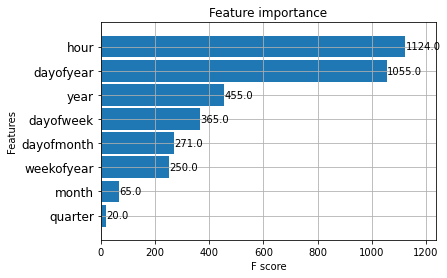

In [36]:
feature_importance = plot_importance(xgb, height=0.9)
feature_importance

In [37]:
predicted_results = xgb.predict(testX)
predicted_results

array([0.0033923, 0.0033923, 0.0033923, ..., 0.0033923, 0.0033923,
       0.0033923], dtype=float32)

# Evaluation Metrics

In [38]:
val = timeseries_evaluation_metrics_func(testY, predicted_results)


MSE is : 19622.821061618542
MAE is : 59.995325116599574
RMSE is : 140.0814800807678


In [39]:
# Making dataframe of TestY and predicted value

In [40]:
df2

,Irradiance
Date,
2014-01-01 00:30:00,0.00
2014-01-01 01:30:00,0.00
2014-01-01 02:30:00,1.45
2014-01-01 03:30:00,150.72
2014-01-01 04:30:00,373.87
...,...
2020-12-31 19:30:00,0.00
2020-12-31 20:30:00,0.00
2020-12-31 21:30:00,0.00


In [41]:
predicted_test_df = df2.copy()
predicted_test_df = df2[46026:]
predicted_test_df['Pred_testy'] = predicted_results
predicted_test_df.columns = ['Test_Y','Predicted_test_y']

In [42]:
predicted_test_df

,Test_Y,Predicted_test_y
Date,,
2019-04-02 18:30:00,0.0,0.003392
2019-04-02 19:30:00,0.0,0.003392
2019-04-02 20:30:00,0.0,0.003392
2019-04-02 21:30:00,0.0,0.003392
2019-04-02 22:30:00,0.0,0.003392
...,...,...
2020-12-31 19:30:00,0.0,0.003392
2020-12-31 20:30:00,0.0,0.003392
2020-12-31 21:30:00,0.0,0.003392


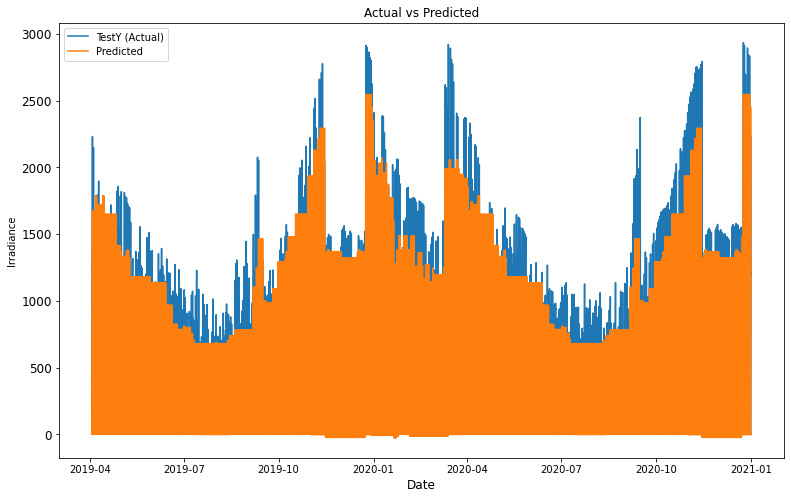

In [43]:
plt.figure(figsize=(13,8))

plt.plot(predicted_test_df['Test_Y'])
plt.plot(predicted_test_df['Predicted_test_y'])
plt.title("Actual vs Predicted")
plt.ylabel("Irradiance")
plt.xlabel("Date", fontsize = 12)

plt.legend(('TestY (Actual)','Predicted'))
plt.show()

In [44]:
test['Prediction'] = predicted_results
Irr_all = pd.concat([test, train], sort=False)
Irr_all = Irr_all.rename(columns={'Irradiation':'Original_value'})



In [45]:
Irr_all

,Irradiance,Prediction
Date,,
2019-04-02 18:30:00,0.0,0.003392
2019-04-02 19:30:00,0.0,0.003392
2019-04-02 20:30:00,0.0,0.003392
2019-04-02 21:30:00,0.0,0.003392
2019-04-02 22:30:00,0.0,0.003392
...,...,...
2019-04-02 13:30:00,0.0,NaN
2019-04-02 14:30:00,0.0,NaN
2019-04-02 15:30:00,0.0,NaN


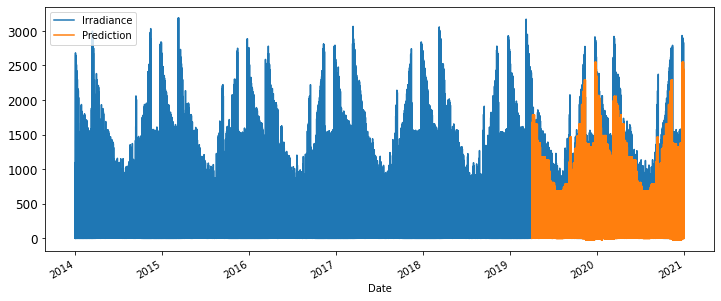

In [46]:
Overview_Complete_Data_And_Prediction = Irr_all[['Irradiance','Prediction']].plot(figsize=(12, 5))

# FUTURE FORECAST 

In [47]:
dti = pd.date_range("2021-01-01 00:30:00", periods=20000, freq="H")

In [48]:
df_future_dates = pd.DataFrame(dti, columns = ['Date'])


In [49]:
df_future_dates.head(300)

,Date
0,2021-01-01 00:30:00
1,2021-01-01 01:30:00
2,2021-01-01 02:30:00
3,2021-01-01 03:30:00
4,2021-01-01 04:30:00
...,...
295,2021-01-13 07:30:00
296,2021-01-13 08:30:00
297,2021-01-13 09:30:00
298,2021-01-13 10:30:00


In [50]:
df_future_dates['Irradiance'] = np.nan

In [51]:
df_future_dates

,Date,Irradiance
0,2021-01-01 00:30:00,NaN
1,2021-01-01 01:30:00,NaN
2,2021-01-01 02:30:00,NaN
3,2021-01-01 03:30:00,NaN
4,2021-01-01 04:30:00,NaN
...,...,...
19995,2023-04-14 03:30:00,NaN
19996,2023-04-14 04:30:00,NaN
19997,2023-04-14 05:30:00,NaN
19998,2023-04-14 06:30:00,NaN


In [52]:
df_future_dates.index = pd.to_datetime(df_future_dates['Date'], format='%Y-%m-%d %H:%M:%S')
df_future_dates.head()

,Date,Irradiance
Date,,
2021-01-01 00:30:00,2021-01-01 00:30:00,NaN
2021-01-01 01:30:00,2021-01-01 01:30:00,NaN
2021-01-01 02:30:00,2021-01-01 02:30:00,NaN
2021-01-01 03:30:00,2021-01-01 03:30:00,NaN
2021-01-01 04:30:00,2021-01-01 04:30:00,NaN


In [53]:
df_future_dates_copy = df_future_dates.copy()
del df_future_dates_copy['Date']

In [54]:
testX_future, testY_future = create_features(df_future_dates, target_variable='Irradiance')

In [55]:
testX_future

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2021-01-01 00:30:00,0,4,1,1,2021,1,1,53
2021-01-01 01:30:00,1,4,1,1,2021,1,1,53
2021-01-01 02:30:00,2,4,1,1,2021,1,1,53
2021-01-01 03:30:00,3,4,1,1,2021,1,1,53
2021-01-01 04:30:00,4,4,1,1,2021,1,1,53
...,...,...,...,...,...,...,...,...
2023-04-14 03:30:00,3,4,2,4,2023,104,14,15
2023-04-14 04:30:00,4,4,2,4,2023,104,14,15
2023-04-14 05:30:00,5,4,2,4,2023,104,14,15


In [56]:
from xgboost import XGBRegressor



In [57]:
xgb = XGBRegressor(objective= 'reg:linear', n_estimators=1000)
xgb

xgb.fit(trainX, trainY,
        eval_set=[(trainX, trainY), (testX, testY)],
        early_stopping_rounds=50,
        verbose=False) 

[19:08:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [58]:
predicted_results_future = xgb.predict(testX_future)
predicted_results_future

array([-8.2276134e+00, -6.5083456e-01,  2.4504519e+01, ...,
        8.3838306e+02,  9.1627838e+02,  9.9855890e+02], dtype=float32)

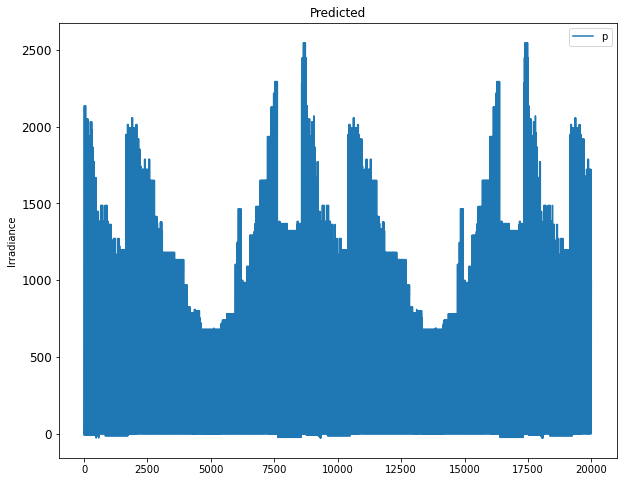

In [59]:
plt.figure(figsize=(10,8))
# plt.plot(list(testY))
plt.plot(list(predicted_results_future))
plt.title("Predicted")
plt.ylabel("Irradiance")
plt.legend('predicted')
plt.show()

In [60]:
df_future_dates_copy['Prediction'] = predicted_results_future
Irr_all_future = pd.concat([df2, df_future_dates_copy], sort=False)
# Irr_all = Irr_all.rename(columns={'Irradiation':'Original_Value'})

In [61]:
predicted_results_future[100:]

array([518.42474, 716.7594 , 833.3127 , ..., 838.38306, 916.2784 ,
       998.5589 ], dtype=float32)

In [62]:
Irr_all_future

,Irradiance,Prediction
Date,,
2014-01-01 00:30:00,0.00,NaN
2014-01-01 01:30:00,0.00,NaN
2014-01-01 02:30:00,1.45,NaN
2014-01-01 03:30:00,150.72,NaN
2014-01-01 04:30:00,373.87,NaN
...,...,...
2023-04-14 03:30:00,NaN,545.941162
2023-04-14 04:30:00,NaN,707.961487
2023-04-14 05:30:00,NaN,838.383057


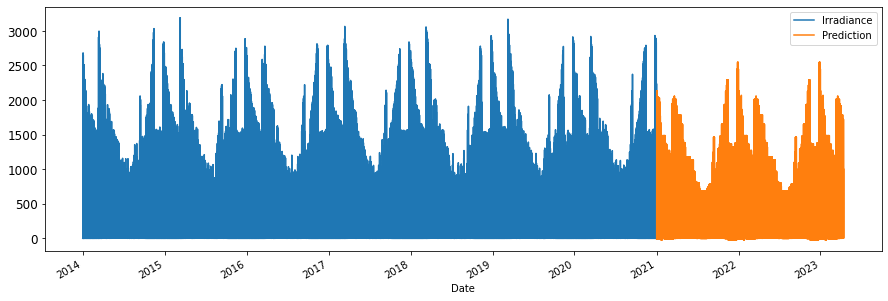

In [63]:
Overview_Complete_Data_And_Prediction_future = Irr_all_future[['Irradiance','Prediction']].plot(figsize=(15, 5))